# Background Analysis

## Objective

* 배경이 변하는 상태를 어떻게 측정할 것인가
  * histogram 변화
  * global illumination 변화
  * color 유무
  
* stable 상태를 어떻게 정의할 것인가
  * 배경 변화 측정값이 변했다 변하지 않았다
  
* object 가 있다면 어떻게 구분할 것인가
  * 어떤 preprocessing 을 해야 object 가 잘 구분될 것인가

In [1]:
%load_ext autoreload
%autoreload 2

## Loading data

In [52]:
from fileutil import FileUtil
from image import ImageLoader
import cv2
import logging

logging.info("Loading images")
bgimages, bgfilelist=ImageLoader.read_image_from_filelist(filename='data/filelist-act5.txt')

In [53]:
objimages, objfilelist=ImageLoader.read_image_from_filelist(filename='data/filelist-act1.txt')

## GUI (Optional, no need to run)

In [3]:
import os
import time
from videofig import videofig

'''
Enter(Return) -- play/pause video (25 frames-per-second default).
Backspace -- play/pause video 5 times slower.
Right/left arrow keys -- advance/go back one frame.
Page down/page up -- advance/go back 30 frames.
Home/end -- go to first/last frame of video.
'''
NUM_IMAGES = len(images)
PLAY_FPS = 20  # set a large FPS (e.g. 100) to test the fastest speed our script can achieve
SAVE_PLOTS = False  # whether to save the plots in a directory

def redraw_fn(f, ax):
    img = images[f]
#     box = boxs[f]

#     x, y, w, h = box
    if not redraw_fn.initialized:
        redraw_fn.img_handle = ax.imshow(img)
#         box_artist = Rectangle((x, y), w, h,
#                                fill=False,  # remove background
#                                lw=2,
#                                edgecolor="red")
#         ax.add_patch(box_artist)
#         redraw_fn.box_handle = box_artist
        redraw_fn.last_time = time.time()
        redraw_fn.text_handle = ax.text(0., 1 - 0.05,
                                        '{} Resolution {}x{}, FPS: {:.2f}'.format(filelist[f], img.shape[1], img.shape[0], 0),
                                        transform=ax.transAxes,
                                        bbox=dict(facecolor='black', alpha=0.5),
                                        color='white', size=20)
        redraw_fn.initialized = True
    else:
        redraw_fn.img_handle.set_array(img)
#         redraw_fn.box_handle.set_xy((x, y))
#         redraw_fn.box_handle.set_width(w)
#         redraw_fn.box_handle.set_height(h)
        current_time = time.time()
        redraw_fn.text_handle.set_text('{} Resolution {}x{}, FPS: {:.2f}'.format(filelist[f], img.shape[1], img.shape[0],
                                                                              1 / (current_time - redraw_fn.last_time)))
        redraw_fn.last_time = current_time


redraw_fn.initialized = False



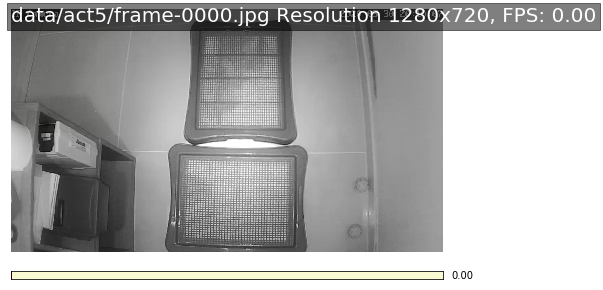

In [4]:
if not SAVE_PLOTS:
    videofig(NUM_IMAGES, redraw_fn, play_fps=PLAY_FPS)
else:
    videofig(NUM_IMAGES, redraw_fn, play_fps=PLAY_FPS, save_dir='example2_save')

## 배경이 변하는 상태를 어떻게 측정할 것인가

## ROI

C:\Users\k\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


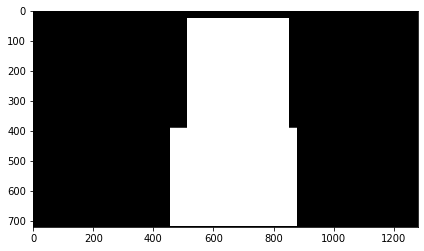

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from image import ImageUtil
import numpy as np
from matplotlib.collections import PatchCollection

roi=[404, 0, 1006, 680]
rx, ry, rw, rh=ImageUtil.coord(roi)

mask=ImageLoader.read_image('data/mask1.png')

fig, ax=plt.subplots(1)
ax.imshow(mask.astype('uint8'))

patches = []
rect=mpatches.FancyBboxPatch(
    [rx, ry], rw, rh, 
    boxstyle=mpatches.BoxStyle("Round", pad=0.02))

colors = np.linspace(0, 1, len(patches))
collection = PatchCollection(patches, cmap=plt.cm.hsv, alpha=0.3)
collection.set_array(np.array(colors))
ax.add_collection(collection)
fig.tight_layout()

fig.show()

### rhratio = roi histogram / global histogram

In [61]:
# images=objimages
images=bgimages

#### Extracting ROI histogram, Global histogram 

In [62]:
hlist=[]

for i, image in enumerate(images):
    ftr=FeatureExtractor(image, roi)
    # use make image for roi
    rh=ftr.get_histogram(mask).transpose()
    ftg=FeatureExtractor(image, None)
    gh=ftg.get_histogram().transpose()
    hlist.append((rh, gh))
    
# plt.ioff()
# x=np.linspace(0, 256, 256)
# fig, ax=plt.subplots(1, 2, figsize=(20, 5))
# ax[0].imshow(image)
# ax[1].plot(x, rh, 'r')
# ax[1].plot(x, gh, 'g')
# fig.show()

#### Comparing curruent frame vs previous one

In [63]:
rhlist=[ x[0] for x in hlist ]
ghlist=[ x[1] for x in hlist ]

dhlist=[(0, 0)]
for i in range(1, len(rhlist)):
    crh=rhlist[i]
    prh=rhlist[i-1]
    
    cgh=ghlist[i]
    pgh=ghlist[i-1]

    drh=FeatureExtractor.compare_histogram(crh, prh)
    dgh=FeatureExtractor.compare_histogram(cgh, pgh)
    
    dhlist.append((drh, dgh))

#### showing difference

In [69]:
drhlist=[ x[0] for x in dhlist ]
dghlist=[ x[1] for x in ghlist ]

# 백그라운드 변화 empirical threshold : 0.4
Tr=0.4
ridx=np.where(np.array(drhlist) > Tr)[0]
print(ridx)
Tg=0.02
gidx=np.where(np.array(dghlist) > Tg)[0]
print(gidx)

[ 377  385  389  543  556  558  559  731  739 1076 1078 1079 1080 1773
 1799 1803 1805 1806 1812]
[ 385  386 1773 1774 1775 1776 1777 1778 1779 1780 1781 1782 1783 1784
 1785 1786 1787 1788 1789 1790 1791 1792 1799 1800 1801 1802]


C:\Users\k\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


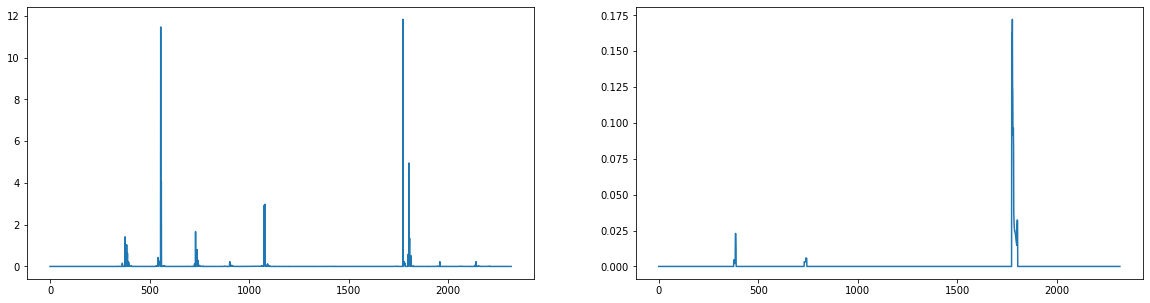

In [68]:
fig, ax=plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(drhlist)
ax[1].plot(dghlist)
fig.show()

In [4]:
from image import FeatureExtractor
#import importlib
#importlib.reload(image)
# reload(image)
nsamples=200

features=[]
for image in images:
    ft=FeatureExtractor(image, roi)
    h=ft.get_histogram()
    c=np.var(ft.get_color_variance(nsamples)
    ic=ft.is_color(nsamples)
    features.append((h, c, ic)
                    
fig, ax=plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(image)
ax[1].plot(np.linspace(0, 256, 256), h.transpose())
ax[2].hist(c)

KeyboardInterrupt: 